In [1]:
from kedro.framework.context import load_context
from kedro.config import ConfigLoader
from kedro.io import DataCatalog
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

conf_loader = ConfigLoader(['../conf/base'])
conf_catalog = conf_loader.get("catalog*", "catalog/**")
new_catalog = DataCatalog.from_config(conf_catalog)

current_dir = Path.cwd()  # this points to 'notebooks/' folder
proj_path = current_dir.parent  # point back to the root of the project
context = load_context(proj_path)

c:\users\danilomotta\envs\mlinvest_env\lib\site-packages\fsspec\implementations\local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [7]:
%%time
df = context.catalog.load("ibov_dataset")
df.head()

2021-03-20 14:25:58,952 - kedro.io.data_catalog - INFO - Loading data from `ibov_dataset` (AppendableCSVDataSet)...
Wall time: 11.6 s


,data_pregao,cod_papel,preco_abertura,preco_maximo,preco_minimo,preco_ultimo,num_negocios
0,2019-01-02 00:00:00,AALR3,13.31,13.50,13.25,13.25,856.0
1,2019-01-02 00:00:00,AAPL34,60.71,60.71,59.89,60.41,45.0
2,2019-01-02 00:00:00,ABBV34,342.84,342.84,342.84,342.84,1.0
3,2019-01-02 00:00:00,ABCB4,16.47,17.20,16.35,17.12,3477.0
4,2019-01-02 00:00:00,ABEV3,15.40,16.30,15.40,16.15,45941.0


In [18]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.feeds as btfeed

# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                # current close less than previous close
                if self.dataclose[-1] < self.dataclose[-2]:
                    # previous close less than the previous close
                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


def run_backtest(data):
    
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(TestStrategy)
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    # Add the Data Feed to Cerebro
    cerebro.broker.setcommission(commission=0.02)
    cerebro.adddata(data)
    # Set our desired cash start
    cerebro.broker.setcash(50000.0)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    # Run over everything
    cerebro.run()
    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    # Plot the result
    cerebro.plot(style='bar')

In [10]:
df["data_pregao"] = pd.to_datetime(df["data_pregao"])

In [13]:
# df = df[df.data_pregao>='2015-01-01']
df["data_pregao"] = pd.to_datetime(df["data_pregao"])

In [15]:
df = df.sort_values(by="data_pregao")
df.head()

,data_pregao,cod_papel,preco_abertura,preco_maximo,preco_minimo,preco_ultimo,num_negocios
2314871,2000-01-03,GOAU3FF,62.00,62.00,52.01,52.01,2.0
2412326,2000-01-03,MAGS7FF,2.31,2.31,2.31,2.31,1.0
2412327,2000-01-03,MAGS7,2.31,2.31,2.31,2.31,1.0
2448314,2000-01-03,INEPB10,0.74,0.91,0.73,0.83,62.0
2414246,2000-01-03,CMIG4,40.50,40.50,38.10,40.00,269.0


In [16]:
PAPEL = "OIBR3"

data = bt.feeds.PandasData(dataname=df.loc[df.cod_papel==PAPEL],
                          datetime='data_pregao',
                          open='preco_abertura',
                          high='preco_maximo',
                          low='preco_minimo',
                          close='preco_ultimo',
                          volume='num_negocios',
                          openinterest=None)

Starting Portfolio Value: 50000.00
2012-04-09, Close, 11.76
2012-04-10, Close, 11.30
2012-04-11, Close, 10.85
2012-04-11, BUY CREATE, 10.85
2012-04-12, BUY EXECUTED, 10.88
2012-04-12, Close, 10.70
2012-04-13, Close, 10.69
2012-04-16, Close, 10.60
2012-04-17, Close, 10.75
2012-04-18, Close, 10.94
2012-04-19, Close, 11.15
2012-04-19, SELL CREATE, 11.15
2012-04-20, SELL EXECUTED, 11.15
2012-04-20, Close, 11.31
2012-04-23, Close, 11.74
2012-04-24, Close, 12.53
2012-04-25, Close, 12.55
2012-04-26, Close, 12.45
2012-04-27, Close, 12.79
2012-04-30, Close, 12.89
2012-05-02, Close, 11.35
2012-05-03, Close, 11.35
2012-05-04, Close, 11.28
2012-05-07, Close, 11.32
2012-05-08, Close, 11.38
2012-05-09, Close, 11.45
2012-05-10, Close, 11.43
2012-05-11, Close, 11.10
2012-05-11, BUY CREATE, 11.10
2012-05-14, BUY EXECUTED, 10.92
2012-05-14, Close, 10.80
2012-05-15, Close, 10.50
2012-05-16, Close, 10.35
2012-05-17, Close, 9.90
2012-05-18, Close, 10.00
2012-05-21, Close, 10.25
2012-05-21, SELL CREATE, 10.

2014-05-29, Close, 2.02
2014-05-29, BUY CREATE, 2.02
2014-05-30, BUY EXECUTED, 2.00
2014-05-30, Close, 2.05
2014-06-02, Close, 2.03
2014-06-03, Close, 2.12
2014-06-04, Close, 2.12
2014-06-05, Close, 2.19
2014-06-06, Close, 2.22
2014-06-06, SELL CREATE, 2.22
2014-06-09, SELL EXECUTED, 2.23
2014-06-09, Close, 2.29
2014-06-10, Close, 2.37
2014-06-11, Close, 2.29
2014-06-13, Close, 2.23
2014-06-13, BUY CREATE, 2.23
2014-06-16, BUY EXECUTED, 2.23
2014-06-16, Close, 2.21
2014-06-17, Close, 2.29
2014-06-18, Close, 2.29
2014-06-20, Close, 2.28
2014-06-23, Close, 2.25
2014-06-24, Close, 2.19
2014-06-24, SELL CREATE, 2.19
2014-06-25, SELL EXECUTED, 2.20
2014-06-25, Close, 2.18
2014-06-25, BUY CREATE, 2.18
2014-06-26, BUY EXECUTED, 2.18
2014-06-26, Close, 2.25
2014-06-27, Close, 2.14
2014-06-30, Close, 2.08
2014-07-01, Close, 1.96
2014-07-02, Close, 1.92
2014-07-03, Close, 1.87
2014-07-03, SELL CREATE, 1.87
2014-07-04, SELL EXECUTED, 1.89
2014-07-04, Close, 1.87
2014-07-07, Close, 1.89
2014-07-08

2016-05-09, Close, 0.80
2016-05-10, Close, 0.81
2016-05-10, SELL CREATE, 0.81
2016-05-11, SELL EXECUTED, 0.82
2016-05-11, Close, 0.84
2016-05-12, Close, 0.83
2016-05-13, Close, 0.81
2016-05-13, BUY CREATE, 0.81
2016-05-16, BUY EXECUTED, 0.82
2016-05-16, Close, 0.81
2016-05-17, Close, 0.80
2016-05-18, Close, 0.81
2016-05-19, Close, 0.80
2016-05-20, Close, 0.81
2016-05-23, Close, 0.81
2016-05-23, SELL CREATE, 0.81
2016-05-24, SELL EXECUTED, 0.81
2016-05-24, Close, 0.81
2016-05-25, Close, 0.84
2016-05-27, Close, 0.92
2016-05-30, Close, 0.91
2016-05-31, Close, 0.89
2016-05-31, BUY CREATE, 0.89
2016-06-01, BUY EXECUTED, 0.88
2016-06-01, Close, 1.03
2016-06-02, Close, 1.27
2016-06-03, Close, 1.29
2016-06-06, Close, 1.30
2016-06-07, Close, 1.39
2016-06-08, Close, 1.49
2016-06-08, SELL CREATE, 1.49
2016-06-09, SELL EXECUTED, 1.51
2016-06-09, Close, 1.79
2016-06-10, Close, 1.78
2016-06-13, Close, 1.66
2016-06-13, BUY CREATE, 1.66
2016-06-14, BUY EXECUTED, 1.76
2016-06-14, Close, 1.27
2016-06-15

2018-03-23, SELL EXECUTED, 4.31
2018-03-23, Close, 4.10
2018-03-26, Close, 3.98
2018-03-26, BUY CREATE, 3.98
2018-03-27, BUY EXECUTED, 3.99
2018-03-27, Close, 3.90
2018-03-28, Close, 3.70
2018-03-29, Close, 3.94
2018-04-02, Close, 3.88
2018-04-03, Close, 3.86
2018-04-04, Close, 3.99
2018-04-04, SELL CREATE, 3.99
2018-04-05, SELL EXECUTED, 4.03
2018-04-05, Close, 4.04
2018-04-06, Close, 3.98
2018-04-09, Close, 3.90
2018-04-09, BUY CREATE, 3.90
2018-04-10, BUY EXECUTED, 3.90
2018-04-10, Close, 3.92
2018-04-11, Close, 3.97
2018-04-12, Close, 3.85
2018-04-13, Close, 3.81
2018-04-16, Close, 3.74
2018-04-17, Close, 3.70
2018-04-17, SELL CREATE, 3.70
2018-04-18, SELL EXECUTED, 3.73
2018-04-18, Close, 3.73
2018-04-19, Close, 3.71
2018-04-20, Close, 3.82
2018-04-23, Close, 3.77
2018-04-24, Close, 3.81
2018-04-25, Close, 3.83
2018-04-26, Close, 3.82
2018-04-27, Close, 3.90
2018-04-30, Close, 3.87
2018-05-02, Close, 3.88
2018-05-03, Close, 3.79
2018-05-04, Close, 3.96
2018-05-07, Close, 3.87
2018

2019-11-21, Close, 1.00
2019-11-22, Close, 0.97
2019-11-22, Close, 0.97
2019-11-25, Close, 0.97
2019-11-25, Close, 0.97
2019-11-26, Close, 0.95
2019-11-26, Close, 0.95
2019-11-27, Close, 0.94
2019-11-27, Close, 0.94
2019-11-28, Close, 0.93
2019-11-28, Close, 0.93
2019-11-29, Close, 0.92
2019-11-29, Close, 0.92
2019-12-02, Close, 0.92
2019-12-02, Close, 0.92
2019-12-03, Close, 0.93
2019-12-03, Close, 0.93
2019-12-04, Close, 0.93
2019-12-04, Close, 0.93
2019-12-05, Close, 0.90
2019-12-05, Close, 0.90
2019-12-06, Close, 0.95
2019-12-06, Close, 0.95
2019-12-09, Close, 0.93
2019-12-09, Close, 0.93
2019-12-10, Close, 0.94
2019-12-10, Close, 0.94
2019-12-11, Close, 0.93
2019-12-11, Close, 0.93
2019-12-12, Close, 0.95
2019-12-12, Close, 0.95
2019-12-13, Close, 0.96
2019-12-13, Close, 0.96
2019-12-16, Close, 0.93
2019-12-16, Close, 0.93
2019-12-17, Close, 0.93
2019-12-17, Close, 0.93
2019-12-18, Close, 0.93
2019-12-18, Close, 0.93
2019-12-19, Close, 0.88
2019-12-19, Close, 0.88
2019-12-20, Clos

<IPython.core.display.Javascript object>


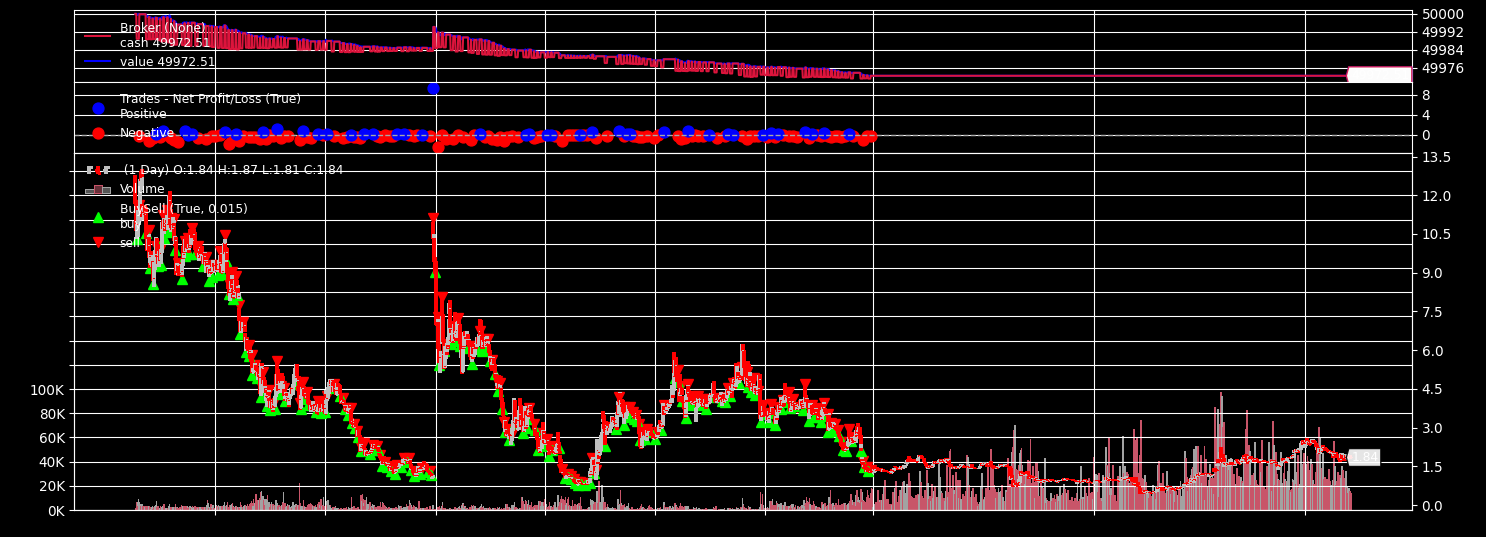

In [19]:
run_backtest(data)